In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchmetrics import Perplexity
import re
import torch
from torch.nn.utils import clip_grad_norm_
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

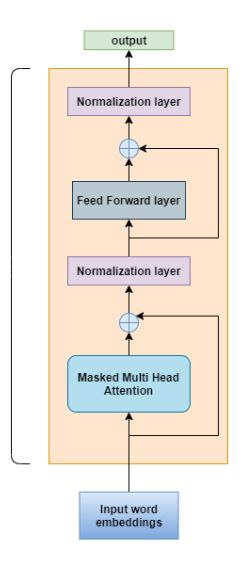

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None, hiddens=None):
    model.train()
    mi = Perplexity().to(device)
    loss_train = AverageMeter()
    with tqdm(train_loader, unit='batch') as tepochs:
        for x_batch, y_batch in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            yp = model(x_batch.to(device))
            loss = loss_fn(yp.transpose(2, 1).to(device), y_batch.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            maz = mi(yp, y_batch.to(device))

            tepochs.set_postfix(loss=loss_train.avg, pre=mi.compute())
            loss_train.update(loss.item())
    return model, loss_train.avg, mi.compute().item()

def evaluate(model, test_loader, loss_fn):
    model.eval()
    mi = Perplexity().to(device)
    loss_test = AverageMeter()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            yp = model(x_batch.to(device))
            loss = loss_fn(yp.transpose(2, 1).to(device), y_batch.to(device))
            loss_test.update(loss.item())
            maz = mi(yp, y_batch)
    print(mi.compute())
    return loss_test.avg, mi.compute().item()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
tokenizer = get_tokenizer('basic_english')
train, valid, test = WikiText2()

In [ ]:
eos = ['eos']
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# HYPER PARAMETERS SHOULD BE CHANGED WITH OBSESSION
bs = 40
seq = 50
step = seq
n_embed = 400
n_head = 4
n_layer = 2
main_dropout = 0.2
attention_dropout = 0.4
embedding_dropout = 0.2
mh_dropout = 0.3
ffwd_dropout = 0.3
block_dropout = 0.2
layer_dropout = 0.2
last_layer_dropout = 0.3

In [ ]:
class WikiSet(Dataset):
    
    def __init__(self, text, vocab=None):
        # cleaning and tokenizing data
        # NOT JUST SENDING EVERY SINGLE TRASH TO MODEL WITHOUT ANY CLEANES TO GET LOWER LOSS
        tokens = [tokenizer(sentence) + eos for sentence in
         ''.join(
             [word.lower() for word in 
                  ''.join([idx for idx in text]) if re.match("[A-Za-z0-9.',\s]", word)] 
         ).splitlines()
        if len(tokenizer(sentence)) > 20] 

        # building or getting vocab from input args
        if vocab:
            self.vocab = vocab  
        else:
            self.vocab = build_vocab_from_iterator(tokens, min_freq=3) # creating vocab
            self.vocab.set_default_index(self.vocab['unk']) # unk tag is set to default

        sequences = torch.LongTensor(
            [self.vocab[i] for z in tokens for i in z]).unfold(0, seq, step) # SHAPING DATA with torch.unfold()

        self.X, self.y = (lambda x: (x[:, :-1], x[:, 1:]))(sequences) # SEPERATING X, y
    
    
    def __getitem__(self, ind):
        return self.X[ind], self.y[ind]
    
    def __call__(self):
        # returning vocab for valid and test
        return self.vocab
    
    def __len__(self):
        return len(self.X)

In [ ]:
train_set = WikiSet(train)
vocab = train_set()
valid_set = WikiSet(valid, vocab)


In [ ]:
train_loader = DataLoader(train_set, bs, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_set, bs, shuffle=1024, drop_last=True) # SETTING SHUFFLE TO SOME SEED

In [ ]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(x.size(0), 1, x.size(2)).bernoulli_(1 - dropout)
        mask = m.requires_grad_(False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x
# LOCKED DROPOUT WITH Batch, Sequences, Features SHAPE

def embedded_dropout(embed, words, dropout=0.1, scale=None):
    if dropout:
        mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
        masked_embed_weight = mask * embed.weight
    else:
        masked_embed_weight = embed.weight
    if scale:
        masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

    padding_idx = embed.padding_idx
    if padding_idx is None:
        padding_idx = -1

    X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
    )
    return X

# COPIED FROM AWD-LSTM ARTICLE GITHUB
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, inp, head_size):
        super().__init__()
        self.key = nn.Linear(inp, head_size)
        self.query = nn.Linear(inp, head_size)
        self.value = nn.Linear(inp, head_size)
        
        self.register_buffer('tril', torch.tril(torch.ones(seq, seq)))
        self.att_dropout = nn.Dropout(attention_dropout)
    
    def forward(self, x):
        B, T, C = x.shape

        key = self.key(x)
        value = self.value(x)
        query = self.query(x)

        den = C ** 0.5 
        num = (query @ key.transpose(-2, -1)) / den
        masked_num = num.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # creating Mask 
        scaled = torch.nn.functional.softmax(masked_num, dim=-1)
        scaled = self.att_dropout(scaled) # ATTENTION DROPOUT
        z = scaled @ value
         # Attention = Softmax(q@k.t() / math.sqrt(q.shape[-1])) @ v
        return z

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, head_size, inp):
        super().__init__()

        self.heads = nn.ModuleList([MaskedSelfAttention(inp=inp, head_size=head_size) for head in range(n_head)])
        self.projection = nn.Linear(inp, inp)
        self.dropout = LockedDropout()
    
    def forward(self, x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        y = self.projection(x)
        return self.dropout(y, mh_dropout)

class FeedForward(nn.Module):
    def __init__(self, inp):
        super().__init__()
        self.layer = nn.Linear(inp, inp*4)
        self.layer2 = nn.Linear(inp*4, inp)
        self.relu = nn.ReLU()
        self.dropout = LockedDropout()
    
    def forward(self, x):
        x = self.relu(self.layer(x))
        x = self.dropout(x, ffwd_dropout)
        y = self.layer2(x)
        return self.dropout(y, ffwd_dropout)


class DecoderBlock(nn.Module):
    def __init__(self, n_head, inp):
        super().__init__()
        if inp % n_head != 0:
            raise ValueError('INPUT SIZE SHOULD BE DIVIDABLE ON NUMBER OF HEADS')
        head_size = inp // n_head
        self.MHA = MultiHeadAttention(n_head=n_head, head_size=head_size, inp=inp)
        self.ln = nn.LayerNorm(inp)
        self.ffw = FeedForward(inp)
        self.dropout = LockedDropout()
    
    def forward(self, x):
        temp = self.MHA(x)
        x = self.dropout(self.ln(temp + x), block_dropout)
        temp = self.ffw(x)
        x = self.dropout(self.ln(temp + x), block_dropout)
        return x

class MyModel(nn.Module):
    def __init__(self, vocab_size, n_embed, seq, n_layer, n_head):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.position_encoder = PositionalEncoding(n_embed, 0.2, seq)
        self.dropout = LockedDropout()
        self.blocks = nn.Sequential(*[DecoderBlock(n_head=n_head, inp=n_embed) for i in range(n_layer)])
        self.ln = nn.LayerNorm(n_embed)
        self.fc = nn.Linear(n_embed, vocab_size)
        self.embed_dropout = LockedDropout()
        self.fc.weight = self.embedding.weight # Weight tying
        self.init_weights()
    
    def init_weights(self)
        initrange = 0.1
        self.embedding.weight.data.uniform_(-.1, .1)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-.1, .1)
    
    def forward(self, x):
        x = embedded_dropout(self.embedding, x)
        enc = self.position_encoder(x)
        x = self.embed_dropout((x + enc), embedding_dropout)
        x = self.blocks(x)
        x = self.dropout(self.ln(x), last_layer_dropout)
        y = self.fc(x)
        return y

In [ ]:
model = MyModel(vocab_size=len(vocab), n_embed=n_embed, seq=seq, n_layer=n_layer, n_head=n_head).to(device)

In [ ]:
sum(p.numel() for p in model.parameters())

In [ ]:
model

In [ ]:
wd = ?
lr = ?

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lr, wd=wd)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = list()
loss_valid_hist = list()
pre_train_hist = list()
pre_valid_hist = list()
best_pre_valid = torch.inf
epoch_counter = 0

In [ ]:
n = ?
for epoch in range(n):
    model, train_loss, pre = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss, valid_pre = evaluate(model, valid_loader, loss_fn)
    
    
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)
    
    pre_train_hist.append(pre)
    pre_valid_hist.append(valid_pre)

    if valid_pre < best_pre_valid:
        torch.save(model,'modelx1.pt')
        best_pre_valid =  valid_pre
        print('Model SAVED')

    epoch_counter +=1